In [1]:
import preprocess

In [2]:
tst = [2020, 9, 5, "AM"]
ted =  [2020, 9, 8, "AM"]
region = ('CreekSNPPPreprocess', [-119.5, 36.8, -118.9, 37.7])

In [3]:
import FireTime

list_of_ts = list(FireTime.t_generator(tst, ted))
list_of_ts

[[2020, 9, 5, 'AM'],
 [2020, 9, 5, 'PM'],
 [2020, 9, 6, 'AM'],
 [2020, 9, 6, 'PM'],
 [2020, 9, 7, 'AM'],
 [2020, 9, 7, 'PM'],
 [2020, 9, 8, 'AM']]

In [ ]:
!ls -lah ./tests/data/processed

## Once per landcover file

If your landcover file is not in lat,lon then transform it and resave it. You will use this file a bunch later on.

In [ ]:
preprocess.preprocess_landcover()

## Once per region

Preprocess the region to get rid of static flare sources. Save that new "swiss cheese" shape off into a geojson file for later.

In [ ]:
preprocess.preprocess_region(region)

In [ ]:
!ls -lah ./tests/data/processed/

## Once per input file

Next process each NRT file into half day files. First we'll get all the times that are of interest. This could also be done by inspecting all looking at all the files that exist and seeing which have not been preprocessed yet.

In [ ]:
# %%time
# for sat in ["SNPP", "NOAA20"]:
#     for t in list_of_ts[::2]:
#         preprocess.preprocess_NRT_file(t, sat)

In [ ]:
%%time
for sat in ["SNPP"]:
    for t in list_of_ts[::2]:
        preprocess.preprocess_monthly_file(t, sat)

In [ ]:
!ls -lah ./tests/data/processed/SNPP/

## Once per region and t

Do initial filtering and clustering using the preprocessed region and the half day files.

Note: for the purpose of timing I am running the full month, but each of these steps could run in a separate proccess.

In [2]:
region = preprocess.read_region(region)

NameError: name 'preprocess' is not defined

In [5]:
# import FireIO, folium
# region_shp = FireIO.get_reg_shp(region[1])
# df = preprocess.read_preprocessed([2020, 9, 6, 'PM'], sat="SNPP")
# min_lat, max_lat = df['Lat'].min(), df['Lat'].max()
# min_lon, max_lon = df['Lon'].min(), df['Lon'].max()
# df_shp = FireIO.get_reg_shp([min_lon, min_lat, max_lon, max_lat])
# mymap = folium.Map(zoom_start=7)

# folium.GeoJson(df_shp, 
#                style_function=lambda x: {'fillColor': 'pin', 'color': 'red', 'weight': 2}).add_to(mymap)

# for index, row in df.iterrows():
#     folium.CircleMarker(location=[row['Lat'], row['Lon']],
#                         radius=1,  # Define the circle size
#                         color='red',
#                         fill=True,
#                         fill_color='red',
#                         fill_opacity=0.6).add_to(mymap)

# folium.GeoJson(region_shp, 
#                style_function=lambda x: {'color': 'cyan', 'weight': 2}).add_to(mymap)
# mymap

In [4]:
%%time
timestep_skips = []
for t in list_of_ts:
    outfile_path = preprocess.preprocess_region_t(t, sensor="VIIRS", region=region)
    # if outfile_path is None then there were no fire pixels so we need to skip this timestep in later processing
    if outfile_path is None:
        timestep_skips.append(t)
timestep_skips

2024-02-10 17:11:12,923 - FireLog - INFO - filtering and clustering 2020-9-5 AM, VIIRS, CreekSNPPPreprocess
2024-02-10 17:11:12,956 - FireLog - INFO - func:read_preprocessed took: 31.81 ms
2024-02-10 17:11:12,957 - FireLog - INFO - func:preprocess_region_t took: 34.10 ms
2024-02-10 17:11:12,958 - FireLog - INFO - filtering and clustering 2020-9-5 PM, VIIRS, CreekSNPPPreprocess
2024-02-10 17:11:13,051 - FireLog - INFO - func:read_preprocessed took: 93.27 ms
2024-02-10 17:11:13,053 - FireLog - INFO - func:preprocess_region_t took: 95.52 ms
2024-02-10 17:11:13,054 - FireLog - INFO - filtering and clustering 2020-9-6 AM, VIIRS, CreekSNPPPreprocess
2024-02-10 17:11:13,088 - FireLog - INFO - func:read_preprocessed took: 34.16 ms
2024-02-10 17:11:13,089 - FireLog - INFO - func:preprocess_region_t took: 35.34 ms
2024-02-10 17:11:13,089 - FireLog - INFO - filtering and clustering 2020-9-6 PM, VIIRS, CreekSNPPPreprocess
2024-02-10 17:11:13,152 - FireLog - INFO - func:read_preprocessed took: 61.9

CPU times: user 347 ms, sys: 80.1 ms, total: 428 ms
Wall time: 431 ms


[[2020, 9, 6, 'PM']]

In [5]:
!ls -lah ./tests/data/processed/VIIRS/CreekSNPPPreprocess

total 1.2M
drwxr-xr-x 2 root root 6.0K Feb 10 16:54 .
drwxr-xr-x 3 root root 6.0K Feb  9 23:08 ..
-rw-r--r-- 1 root root 5.8K Feb  9 23:08 20200905_AM.txt
-rw-r--r-- 1 root root  59K Feb  9 23:08 20200905_PM.txt
-rw-r--r-- 1 root root 329K Feb  9 23:08 20200906_AM.txt
-rw-r--r-- 1 root root 259K Feb 10 16:54 20200907_AM.txt
-rw-r--r-- 1 root root 113K Feb 10 16:54 20200907_PM.txt
-rw-r--r-- 1 root root 437K Feb 10 16:54 20200908_AM.txt


## Use FireRun test

In [6]:
from FireRun import ProcessNRT

allfires_tuple = ProcessNRT(region[0], tst, ted, timestep_skips)
allfires = allfires_tuple[0]

2024-02-10 17:11:24,172 - FireLog - INFO - STARTING RUN FOR CreekSNPPPreprocess
2024-02-10 17:11:24,183 - FireLog - INFO - func:read_preprocessed took: 2.49 ms
2024-02-10 17:11:24,188 - FireLog - INFO - func:read_preprocessed took: 3.05 ms
2024-02-10 17:11:24,198 - FireLog - INFO - func:read_preprocessed took: 8.33 ms
2024-02-10 17:11:24,206 - FireLog - INFO - func:read_preprocessed took: 6.81 ms
2024-02-10 17:11:24,212 - FireLog - INFO - func:read_preprocessed took: 3.60 ms
2024-02-10 17:11:24,222 - FireLog - INFO - func:read_preprocessed took: 8.32 ms
2024-02-10 17:11:24,225 - FireLog - INFO - --------------------
2024-02-10 17:11:24,225 - FireLog - INFO - Fire tracking at [2020, 9, 5, 'AM']
2024-02-10 17:11:24,782 - FireLog - INFO - func:Fire_expand_rtree took: 554.81 ms
2024-02-10 17:11:24,784 - FireLog - INFO - func:Fire_merge_rtree took: 0.66 ms
2024-02-10 17:11:24,785 - FireLog - INFO - func:invalidate_statfires took: 1.13 ms
2024-02-10 17:11:24,786 - FireLog - INFO - fids_expan

From the logs that Eli shared we expect that for [2023, 9, 6, 'AM'] we should have:

```python
actual_fids_expand = 260
actual_fids_new = 131
actual_fids_merged = 6
actual_fids_invalid = 44
```

In [7]:
allfires

<Allfires at t=[2020, 9, 8, 'AM'] with n_fires=10>

Find a big fire

In [8]:
{fid: fire.n_pixels for fid, fire in allfires.fires.items() if fire.n_pixels > 1000}

{1: 7191}

In [9]:
allfires.fires[1].pixels

,Lat,Lon,FRP,Sat,DT,DS,YYYYMMDD_HHMM,ampm,x,y,initial_cid,t,fid,in_fline
uuid,,,,,,,,,,,,,,
40a52a22-3124-4a1e-9d23-f55d3923bfb7,37.201797,-119.271812,21.04,SNPP,0.442377,0.385693,2020-09-05 10:00:00,AM,-1.692131e+06,-670256.379954,0,2020-09-05,1,True
1a854aa0-2338-40a0-a4ed-551502e0d263,37.199169,-119.277367,4.98,SNPP,0.442199,0.385621,2020-09-05 10:00:00,AM,-1.692670e+06,-670430.137837,0,2020-09-05,1,True
6a5caba4-8db1-40c9-a5db-397ca3a1d85f,37.198254,-119.272469,21.04,SNPP,0.442377,0.385693,2020-09-05 10:00:00,AM,-1.692271e+06,-670629.547556,0,2020-09-05,1,None
1d463919-5e3a-4e49-9744-3a2d7e31f556,37.197338,-119.267548,21.04,SNPP,0.442556,0.385766,2020-09-05 10:00:00,AM,-1.691870e+06,-670829.510435,0,2020-09-05,1,True
dd9e0587-4f2a-4903-a77f-95baf59f6088,37.195644,-119.278160,44.95,SNPP,0.442199,0.385621,2020-09-05 10:00:00,AM,-1.692822e+06,-670798.568062,0,2020-09-05,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1fe029f9-7eb7-4d95-ad24-1a66a6e21937,37.013283,-119.281837,12.27,SNPP,0.520021,0.668137,2020-09-08 10:42:00,AM,-1.697441e+06,-690618.151198,21,2020-09-08,1,None
7bdb5e01-fedf-40a6-9ee0-611eb7450b04,37.010933,-119.273651,2.98,SNPP,0.520420,0.668340,2020-09-08 10:42:00,AM,-1.696792e+06,-691041.281859,21,2020-09-08,1,True
2b5c6282-502d-4d0b-ba6c-5a9f0e75cf99,37.028984,-119.359322,6.00,SNPP,0.514503,0.665318,2020-09-08 10:42:00,AM,-1.703740e+06,-687323.573372,21,2020-09-08,1,None


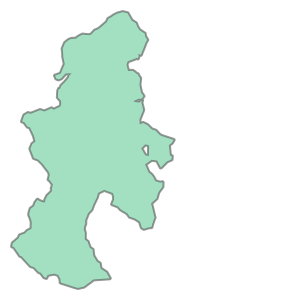

In [10]:
allfires.fires[1].hull

## Experiments with saving fire data

In [ ]:
%%time

from FireConsts import firesrc
import os
OUTPUT_DIR = "/tests/data/processed/"

for fid, fire in allfires.fires.items():
    fire_filename = f"{fid=}.txt"
    output_filepath = os.path.join(OUTPUT_DIR, firesrc, region[0], "fires", fire_filename)
    
    # make nested path if necessary
    os.makedirs(os.path.dirname(output_filepath), exist_ok=True)

    fire.pixels.to_csv(output_filepath, index=False)

## Experiments with land cover

In [ ]:
from FireConsts import dirextdata

import rasterio
import pyproj
import os

In [ ]:
%%time
# read NLCD 500m data
fnmLCT = os.path.join(dirextdata, "NLCD", f"nlcd_export_510m_simplified_latlon.tif")
dataset = rasterio.open(fnmLCT)
samps = list(dataset.sample(fire.newlocs_geo))
vLCT = [s[0] for s in samps]
vLCT

In [ ]:
%%time
# read NLCD 500m data
fnmLCT = os.path.join(dirextdata, "NLCD", f"nlcd_export_510m_simplified_{epsg}.tif")
dataset = rasterio.open(fnmLCT)
samps = list(dataset.sample(fire.newlocs))
vLCT = [s[0] for s in samps]
vLCT

In [ ]:
%%time

locs = fire.newlocs_geo
# read NLCD 500m data
fnmLCT = os.path.join(dirextdata, "NLCD", "nlcd_export_510m_simplified.tif")
dataset = rasterio.open(fnmLCT)
transformer = pyproj.Transformer.from_crs("epsg:4326", dataset.crs)
locs_crs_x, locs_crs_y = transformer.transform(
    # NOTE: EPSG 4326 expected coordinate order latitude, longitude, but
    # `locs` is x (longitude), y (latitude). That's why `l[1]`, then `l[0]`
    # here.
    [l[1] for l in locs],
    [l[0] for l in locs]
)
locs_crs = list(zip(locs_crs_x, locs_crs_y))
samps = list(dataset.sample(locs_crs))
vLCT = [int(s) for s in samps]
vLCT

## Experiments with hulls

Trying out next steps around hulls:

In [ ]:
from FireObj import Cluster, FirePixel
from FireVector import *

In [ ]:
%%time
for d in range(1, 32):
    for ampm in ("AM", "PM"):
        df = read_preprocessed((t[0], t[1], d, ampm), sat, region=region)
        for ic, pixels in df.groupby("initial_cid"):
            hull = cal_hull(pixels[["x", "y"]].values, sensor="viirs")

In [ ]:
biggest_cluster = df.value_counts("initial_cid").index[0]
pixels = df[df["initial_cid"] == biggest_cluster].copy()
pixel_locs = pixels[["x", "y"]].values
hull = cal_hull(pixel_locs, sensor="viirs")

In [ ]:
from utils import timed

In [ ]:
# compute initial hulls
hulls = dict()
for ic, subset in df.groupby("initial_cid"):
    pixel_locs = subset[["x", "y"]].values
    hulls[ic] = cal_hull(pixel_locs, sensor="viirs")

# store hulls
df = pd.merge(df, pd.Series(hulls, name="hull"), how="outer", left_on="initial_cid", right_index=True)